## <center> Analyze A/B Test Results </center>


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

In this project, We will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.loc[df.converted == 1].user_id.nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
Not_Match1 = df.loc[(df.landing_page == 'new_page') & (df.group != 'treatment')].index
Not_Match2 = df.loc[(df.landing_page == 'old_page') & (df.group != 'control')].index
df.loc[(df.landing_page == 'new_page') & (df.group != 'treatment')].user_id.nunique() + \
df.loc[(df.landing_page == 'old_page') & (df.group != 'control')].user_id.nunique()

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. Thus, we will create a new dataframe to have only the data with these records.

a. Store the new dataframe in **df2**.

In [8]:
df2 = df.drop(Not_Match1)
df2.drop(Not_Match2, inplace = True)
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Analysis on df2 

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. Check if any repeated users. 

In [11]:
u1 = df2.loc[df2.user_id.drop_duplicates().index]
#u1.shape, df2.shape
df_diff = pd.concat([df2,u1]).drop_duplicates(keep=False)
df_diff.user_id


2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df_diff

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates('user_id', inplace = True)

`4.` Further investigation on df2

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2[df2.converted == 1].shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_group = df2[df2.group == 'control']
pconverted_control = control_group[control_group.converted == 1].shape[0]/control_group.shape[0]
pconverted_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_group = df2[df2.group == 'treatment']
pconverted_treatment = treatment_group[treatment_group.converted == 1].shape[0]/treatment_group.shape[0]
pconverted_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.landing_page.value_counts()/df2.shape[0]

new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

### Conclusion

**As probaility of converting is not significantly higher in control group we can see that there is no such evidence to conclude that the treatment page will lead to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, we will consider the need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, we can write the null and alternative as follow:

**null :  P_old >= P_new Alternative: P_old < P_new**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
pnew = df2.loc[df2.converted == 1].user_id.nunique()/df2.user_id.nunique()
pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
pold = pnew
pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
nnew_df = df2.query('group == "treatment"')
nnew = nnew_df.shape[0]
nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
nold_df = df2.query('group == "control"')
nold = nold_df.shape[0]
nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
#new_page_converted = np.random.binomial( n = nnew.converted , p = pnew )
new_page_converted = np.random.binomial(n = nnew_df.converted , p = pnew)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial( n = nold_df.converted , p = pold)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
pnew2 = new_page_converted.mean()
pold2 = old_page_converted.mean()
pnew2 - pold2

5.8428599442283263e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
new_page_converted = np.random.binomial(n = nnew , p = pnew, size = 10000) / nnew
old_page_converted = np.random.binomial(n = nold , p = pold, size = 10000) / nold
p_diffs = new_page_converted - old_page_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

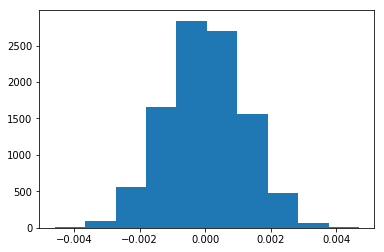

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
observed_difference= df2['converted'][df2['group'] == 'treatment'].mean() - df2['converted'][df2['group'] == 'control'].mean()
(p_diffs > observed_difference).mean(),observed_difference

(0.90469999999999995, -0.0015782389853555567)

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**If we simulate 10000 time the difference between the conversion rates under the null hypothesis, about 97% of the resulting array will be large than actual difference computed directly from the dataset. This value often called p-value which indicates worst-case error ( Type- I error).If this error is smaller than certain threshold we will have enough evidence to reject the null hypothesis and accept alternative hypothesis. Typically this threshold is about 5%. In our case, we don't have enough evidence to reject null hypothesis which means we don't recommend to change to the new page based on this data.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').shape[0]
convert_new = df2.query('group == "treatment" and converted == 1').shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. We can also use `stats.proportions_ztest` to compute the test statistic and p-value.

In [29]:
#z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative = 'smaller')

z_score, p_value

(1.3109241984234394, 0.90505831275902449)

### Conclusion

**We can see that p_value is simular to what we obtained above(about 90 % ). It means that it is not expected that new page will lead to more conversions.** 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, first we need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1 
df2 = df2.join(pd.get_dummies(df.group))
df2.drop(['control'], axis = 1 ,inplace = True)
df2.rename(columns = {'treatment': 'ab_page'}, inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
import statsmodels.api as sm
!pip install --upgrade --use-feature=2020-resolver statsmodels
lg_mod = sm.Logit(df2.converted, df2[['ab_page', 'intercept']])
results = lg_mod.fit()


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --use-feature
Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-24 07:02 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
==================================================================

"""

**The p value given in this summary is the 2 sided test value. This can be related to 1 sided test value with the following formula ( Pside2 = 2(1 - Pside1) ). If we use Pside1 = .9 then Pside2 = .2 which is very close to value obtained above. I am not sure though why it is slightly lower than .2.**

f. Now, we are considering other things that might influence whether or not an individual converts. 

**We can add higher order terms like square or cubic values. In addition we can multiply two features. While this increase model ability to fit more complex data, it turns out that interpreting results will be more difficult.**

g. Now along with testing if the conversion rate changes for different pages, also we will add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.

In [33]:
countries = pd.read_csv('countries.csv')
df_countries = df2.merge(countries , on = 'user_id',how = 'left')
df_countries = df_countries.join(pd.get_dummies(df_countries.country))
df_countries['intercept'] = 1
lg_mod2 = sm.Logit(df_countries.converted, df_countries[['ab_page', 'intercept','UK','US']])
results2 = lg_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-24 07:02 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**It seems like the country columns has no significnce on the model results.** 

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [34]:
df_countries['interaction_CA'] = df_countries['CA'] * df_countries['ab_page']
df_countries['interaction_UK'] = df_countries['UK'] * df_countries['ab_page']
lg_mod3 = sm.Logit(df_countries.converted, df_countries[['ab_page', 'intercept','UK','US','interaction_CA','interaction_UK']])
results3 = lg_mod3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-24 07:02 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
ab_page           -0.0206   0.0137  -1.5052 0.1323 -0.0473  0.0062
intercept         -2.0040   0.0364 -55.0077 0.0000 -2.0754 -1.9326
UK                 0.0118   0.0398   0.2957 0.7674 -0.0663  0.0899
US                 0.0175   0.0377   0.4652 0.6418 -0.0563  0.0914
interaction_CA    -0.0469   0.0538  -0.8718 0.3833 -0.1523  0.0585
interaction_UK     0.0314   0.0266   1.1807 0.2377 -0.0207  0.0835
==================================================================

"""

<a id='conclusions'></a>
## Conclusion

As we have seen in all 3 parts above, it is expected based on the available data that introducing new pages will not lead to more conversions. Hence, we highly recommend to keep the old bage. 